In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly
import plotly.figure_factory as ff

from tqdm import tqdm

In [2]:
import importlib
import sys
import os 
sys.path.insert(0, os.path.abspath(os.path.join('../src/')))
import simulate_multi_data
importlib.reload(simulate_multi_data)

<module 'simulate_multi_data' from '/Users/hwunrow/Documents/GitHub/rt-estimation/src/simulate_multi_data.py'>

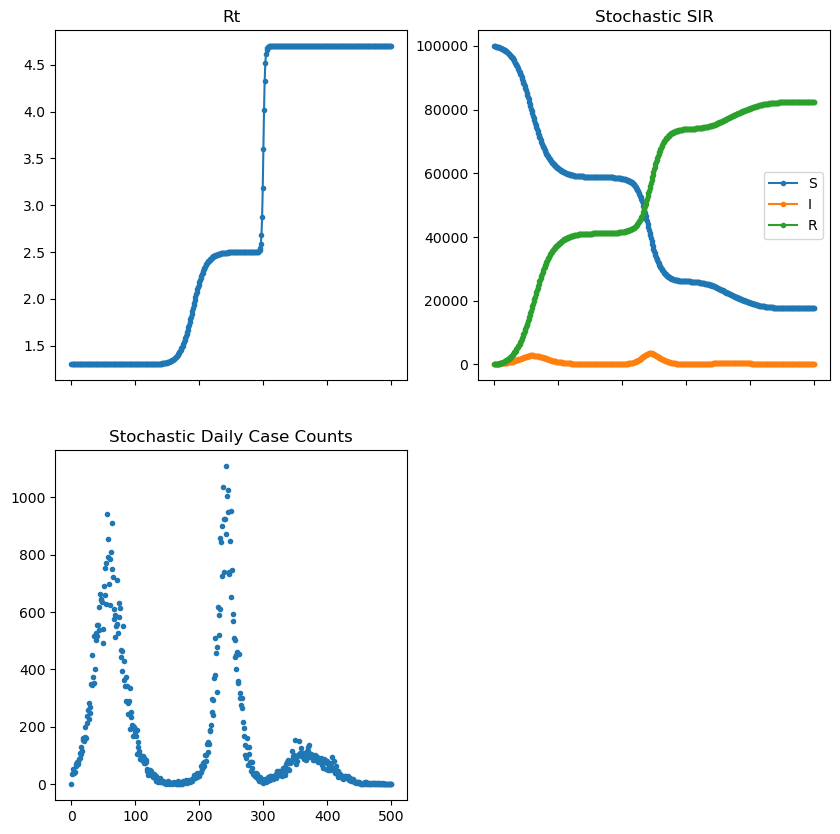

In [3]:
true_params = {
    'rt_m': [1.3, 2.5, 4.7], 
    'midpoint': [190.,300],
    'k': [0.1, 0.8],
    'n_t': 500,
    't_I': 4.,
    'N': 100_000.,
    'S0': 99_900.,
    'I0': 100.,
}

np.random.seed(1994)

# data = simulate_data.simulate_data(**true_params, run_deterministic=True)

data = simulate_multi_data.simulate_multi_data(**true_params, add_noise=True, noise_param=1/50)

data.plot_all()
data.compute_data_distribution()

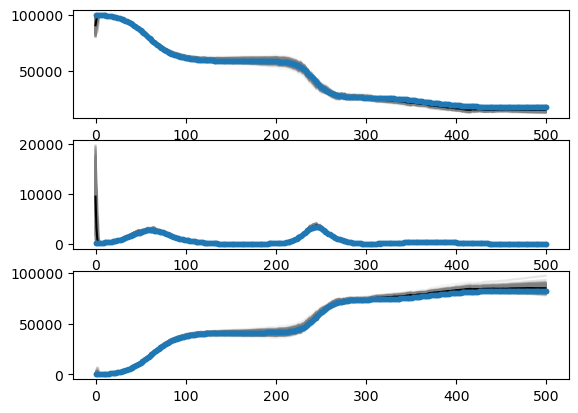

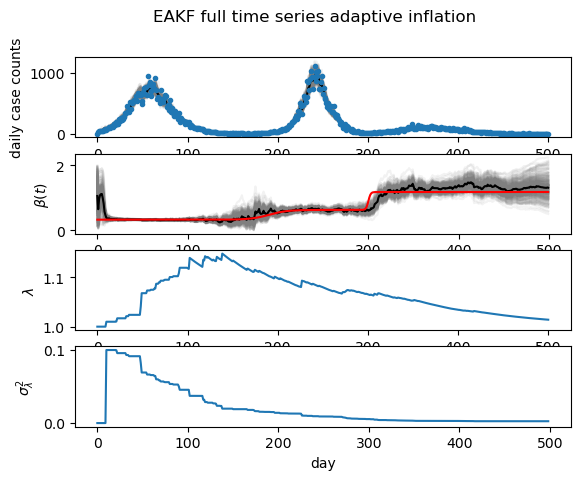

In [4]:
import model_da
importlib.reload(model_da)

model = model_da.SIR_model(data)

import eakf
importlib.reload(eakf)

kf = eakf.EnsembleAdjustmentKalmanFilter(model, m=300)

from numpy.random import uniform

prior = {
    'beta':{
        'dist': uniform,
        'args':{
            'low': 0.1,
            'high': 2.,
        }
    },
    't_I':{
        'dist': "constant",
        # 'args':{
        #     'lower': 1.,
        #     'upper': 12.,
        # }
    },
}

kf.filter(prior)
kf.plot_posterior()

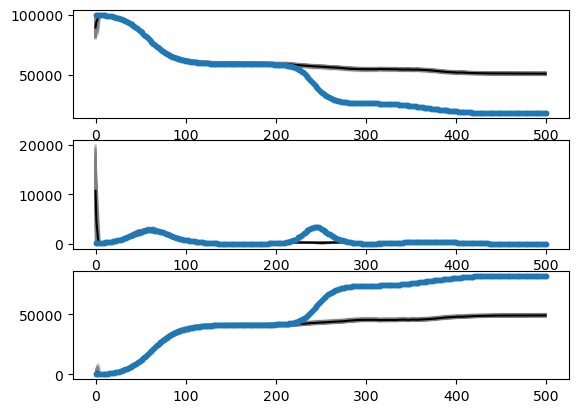

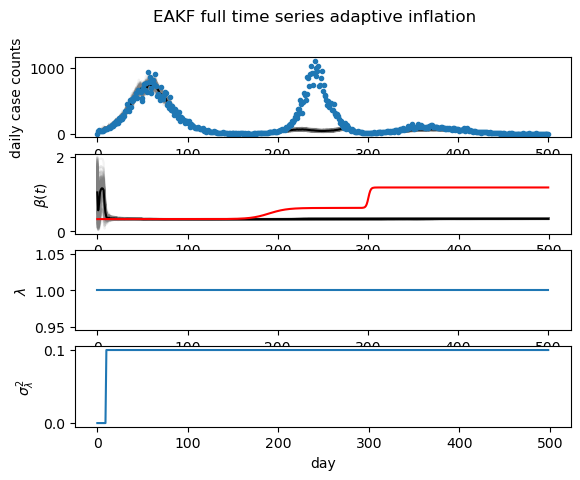

In [5]:
kf_no = eakf.EnsembleAdjustmentKalmanFilter(model, m=300)
kf_no.filter(prior, inf_method="none")
kf_no.plot_posterior()

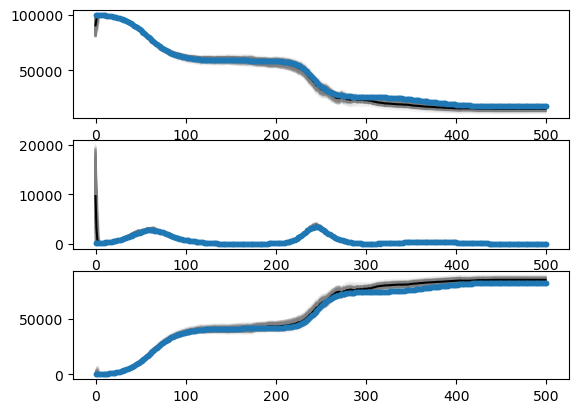

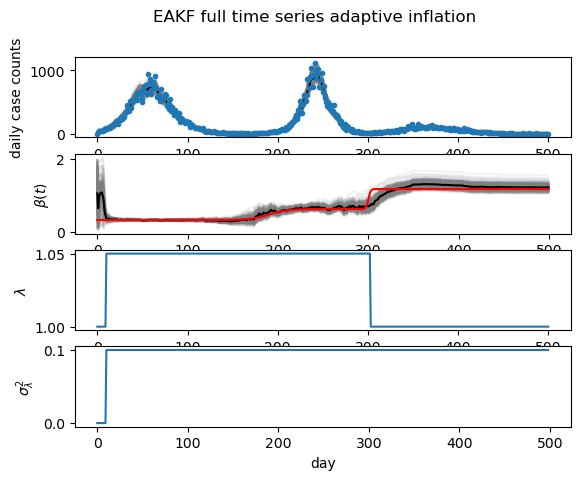

In [6]:
kf_fixed = eakf.EnsembleAdjustmentKalmanFilter(model, m=300)
kf_fixed.filter(prior, inf_method="constant", lam_fixed=1.05)
kf_fixed.plot_posterior()

In [7]:
import enks
importlib.reload(enks)
import posterior_checks
importlib.reload(posterior_checks)

ks = enks.EnsembleSquareRootSmoother(kf)
ks.smooth(window_size=10, plot=False)

In [8]:
# confidence_level = 95
# ci = np.percentile([θ.beta*θ.t_I for θ in kf.θ_list], [100 - confidence_level, confidence_level], axis=1)

# window_size = 10
# ma_filter = np.ones(window_size) / window_size
# eakf_mean = np.convolve(np.mean([θ.beta*θ.t_I for θ in kf.θ_list], axis=1), ma_filter, mode='valid')
# ci_1 = np.convolve(ci[0,:], ma_filter, mode='valid')
# ci_2 = np.convolve(ci[1,:], ma_filter, mode='valid')

# ma_filter = np.ones(window_size) / window_size
# eaks = np.convolve(eakf_mean, ma_filter, mode='valid')
# eaks_ci1 = np.convolve(ci_1, ma_filter, mode='valid')
# eaks_ci2 = np.convolve(ci_2, ma_filter, mode='valid')

# confidence_level = 95
# ci_no = np.percentile([θ.beta*θ.t_I for θ in kf_no.θ_list], [100 - confidence_level, confidence_level], axis=1)

# confidence_level = 95
# ci_fixed = np.percentile([θ.beta*θ.t_I for θ in kf_fixed.θ_list], [100 - confidence_level, confidence_level], axis=1)

In [9]:
# confidence_level = 95
# ci = np.percentile([θ.beta*θ.t_I for θ in kf.θ_list], [100 - confidence_level, confidence_level], axis=1)

# window_size = 5
# ma_filter = np.ones(window_size) / window_size
# eaks = np.convolve(np.mean([θ.beta*θ.t_I for θ in kf.θ_list], axis=1), ma_filter, mode='valid')
# eaks_ci1 = np.convolve(ci[0,:], ma_filter, mode='valid')
# eaks_ci2 = np.convolve(ci[1,:], ma_filter, mode='valid')

# confidence_level = 95
# ci_no = np.percentile([θ.beta*θ.t_I for θ in kf_no.θ_list], [100 - confidence_level, confidence_level], axis=1)

# confidence_level = 95
# ci_fixed = np.percentile([θ.beta*θ.t_I for θ in kf_fixed.θ_list], [100 - confidence_level, confidence_level], axis=1)

In [10]:
confidence_level = 95
ci = np.percentile([θ.beta*θ.t_I for θ in kf.θ_list], [100 - confidence_level, confidence_level], axis=1)

confidence_level = 95
ci_no = np.percentile([θ.beta*θ.t_I for θ in kf_no.θ_list], [100 - confidence_level, confidence_level], axis=1)

confidence_level = 95
ci_fixed = np.percentile([θ.beta*θ.t_I for θ in kf_fixed.θ_list], [100 - confidence_level, confidence_level], axis=1)

eaks = np.mean([θ.beta*θ.t_I for θ in ks.θ_lag_list], axis=1)
eaks_ci1 = np.percentile([θ.beta*θ.t_I for θ in ks.θ_lag_list], [100 - confidence_level, confidence_level], axis=1)[0,:]
eaks_ci2 = np.percentile([θ.beta*θ.t_I for θ in ks.θ_lag_list], [100 - confidence_level, confidence_level], axis=1)[1,:]


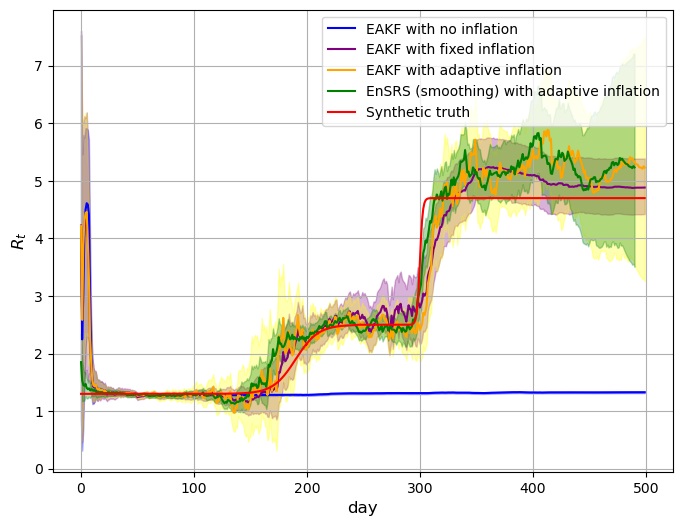

In [11]:
fig, ax = plt.subplots()
fig.set_figwidth(8)
fig.set_figheight(6)

ax.fill_between(np.arange(ci.shape[1]), ci_no[0,:], ci_no[1,:], color='blue', alpha=0.3)
ax.plot(np.mean([θ.beta*θ.t_I for θ in kf_no.θ_list], axis=1), color="blue", label=r"EAKF with no inflation")

ax.fill_between(np.arange(ci.shape[1]), ci_fixed[0,:], ci_fixed[1,:], color='purple', alpha=0.3)
ax.plot(np.mean([θ.beta*θ.t_I for θ in kf_fixed.θ_list], axis=1), color="purple", label=r"EAKF with fixed inflation")

ax.fill_between(np.arange(ci[0,:].shape[0]), ci[0,:], ci[1,:], color='yellow', alpha=0.3)
ax.plot(np.mean([θ.beta*θ.t_I for θ in kf.θ_list], axis=1), color="orange", label=r"EAKF with adaptive inflation")

ax.fill_between(np.arange(len(eaks_ci2)), eaks_ci1, eaks_ci2, color='green', alpha=0.3)
ax.plot(eaks, color="green", label=r"EnSRS (smoothing) with adaptive inflation")

ax.plot(kf_fixed.data.rt, color="red", label=r"Synthetic truth")

ax.set_xlabel("day", fontsize=12)
ax.set_ylabel(r"$R_t$", fontsize=12)

ax.legend()
ax.grid()

plt.savefig(f'rt.svg', format='svg', bbox_inches='tight', transparent=True)

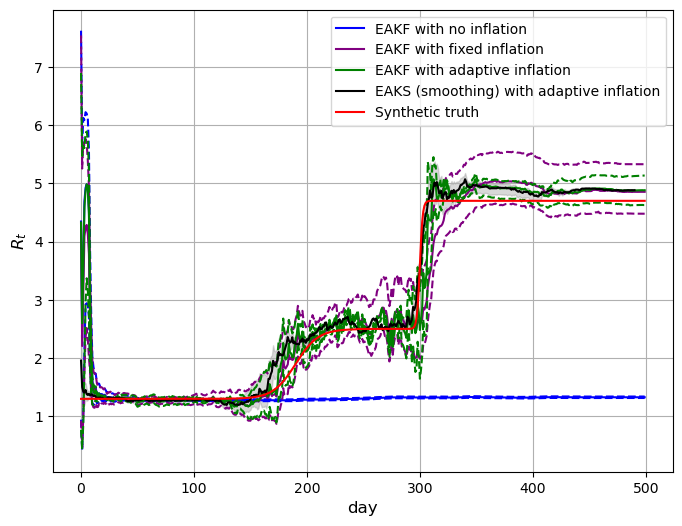

In [184]:
fig, ax = plt.subplots()
fig.set_figwidth(8)
fig.set_figheight(6)

ax.plot(ci_no[0,:], color='blue', linestyle='--')
ax.plot(ci_no[1,:], color='blue', linestyle='--')
ax.plot(np.mean([θ.beta*θ.t_I for θ in kf_no.θ_list], axis=1), color="blue", label=r"EAKF with no inflation")

ax.plot(ci_fixed[0,:], color='purple', linestyle='--')
ax.plot(ci_fixed[1,:], color='purple', linestyle='--')
ax.plot(np.mean([θ.beta*θ.t_I for θ in kf_fixed.θ_list], axis=1), color="purple", label=r"EAKF with fixed inflation")


ax.plot(ci[1,:]*.9, color='green', linestyle='--')
ax.plot(ci[0,:]*1.1, color='green', linestyle='--')
ax.plot(np.mean([θ.beta*θ.t_I for θ in kf.θ_list], axis=1), color="green", label=r"EAKF with adaptive inflation")

ax.fill_between(np.arange(len(eaks_ci2)), eaks_ci1*1.05, eaks_ci2*.95, color='grey', alpha=0.3)
ax.plot(eaks, color="black", label=r"EAKS (smoothing) with adaptive inflation")

ax.plot(kf_fixed.data.rt, color="red", label=r"Synthetic truth")

ax.set_xlabel("day", fontsize=12)
ax.set_ylabel(r"$R_t$", fontsize=12)


ax.legend()
ax.grid()


Percent of observations in 95% CI 99.8%
Percent of observations in 50% CI 40.92%


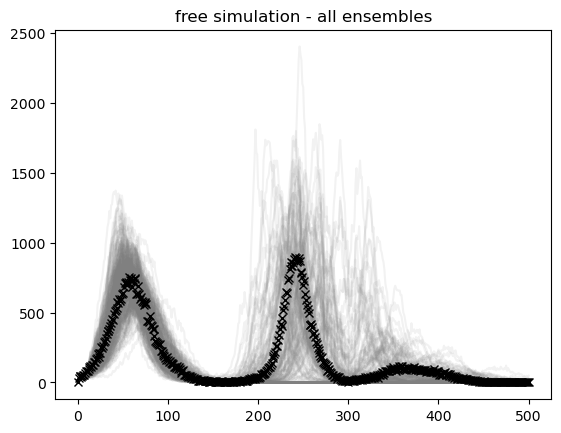

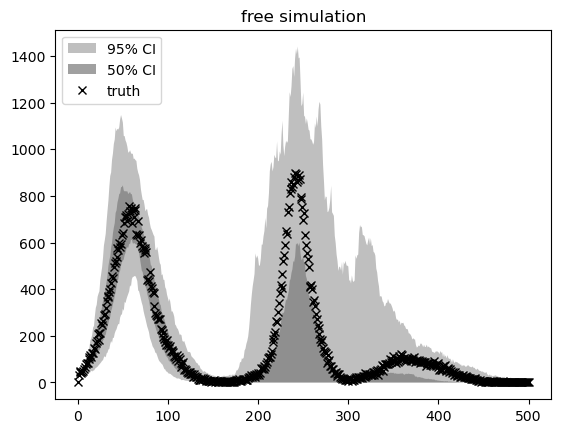

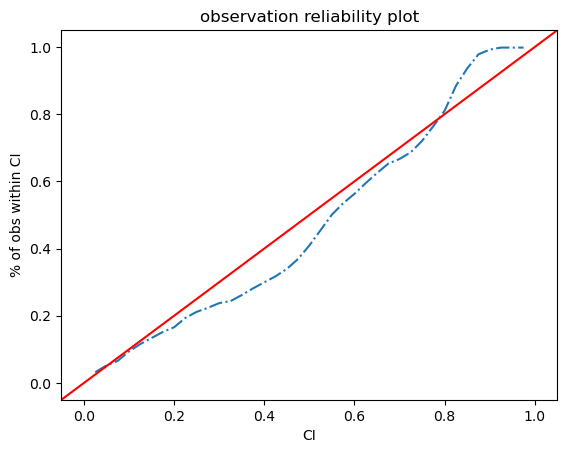

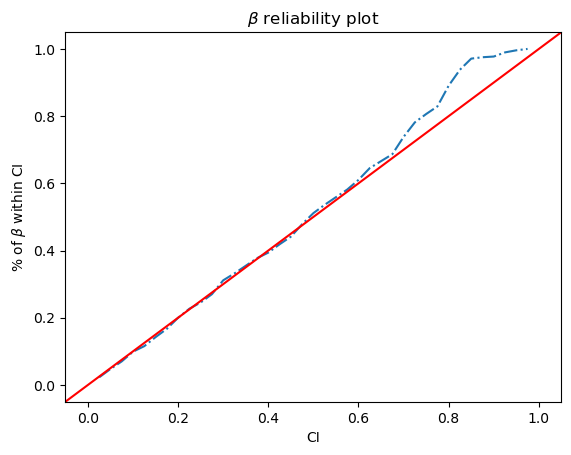

In [185]:
kf.plot_reliability()

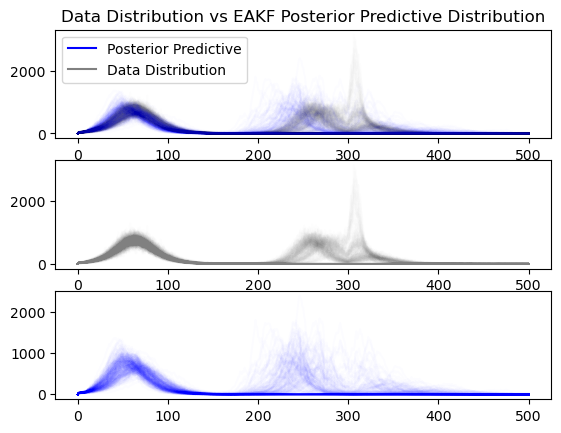

In [186]:
kf.plot_ppc()

Percent of observations in 95% CI 36.13%
Percent of observations in 50% CI 25.35%


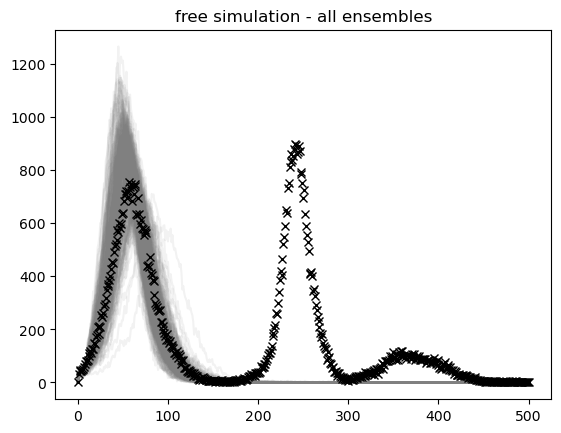

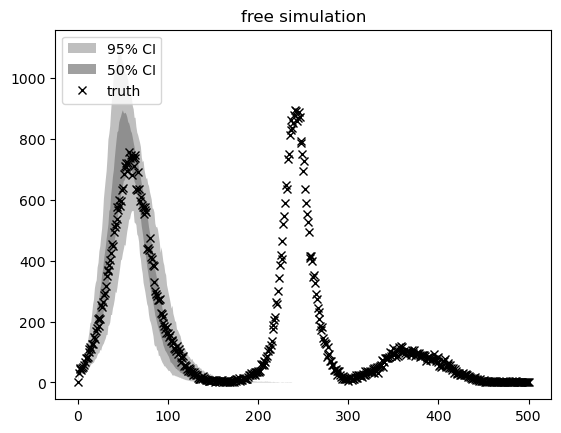

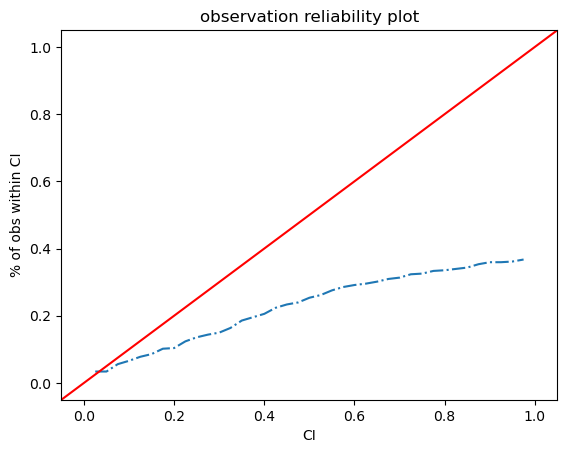

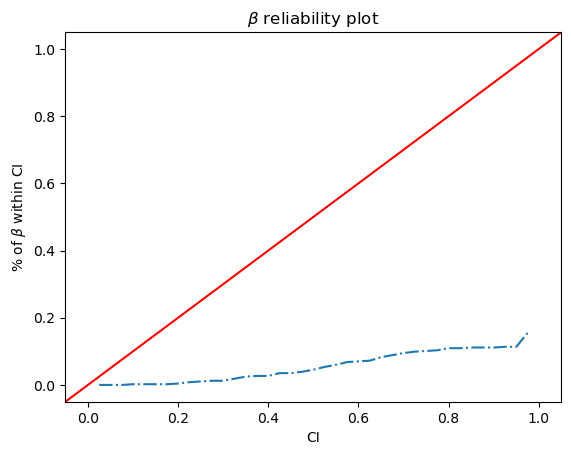

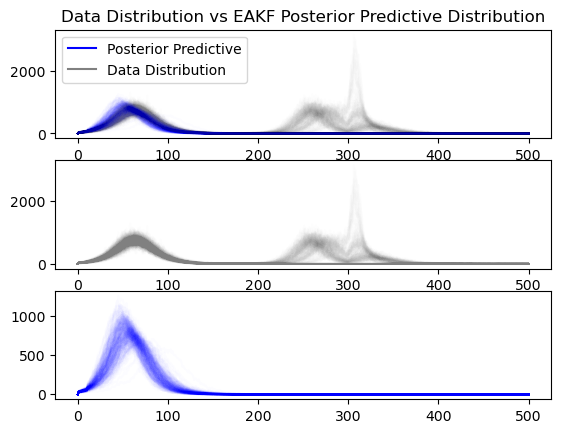

In [187]:
kf_no.plot_reliability()
kf_no.plot_ppc()

Percent of observations in 95% CI 99.6%
Percent of observations in 50% CI 37.92%


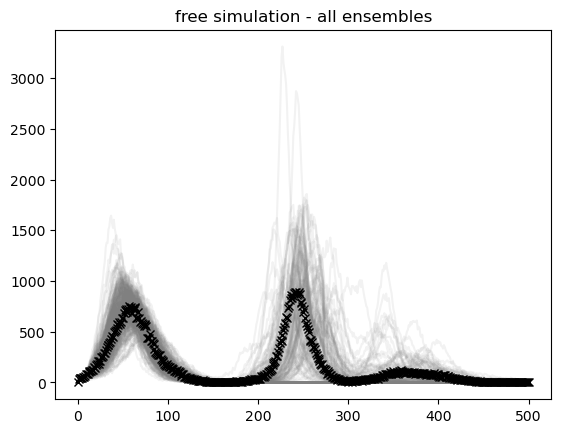

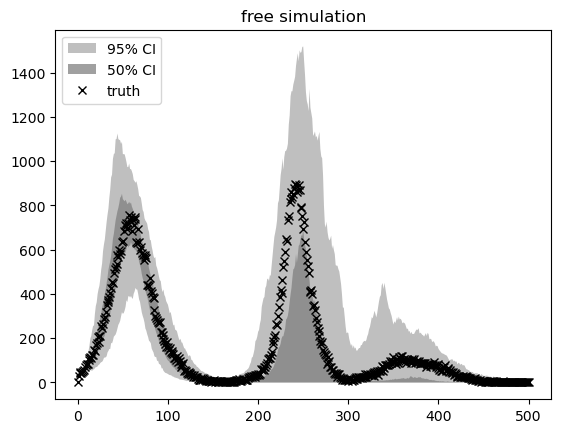

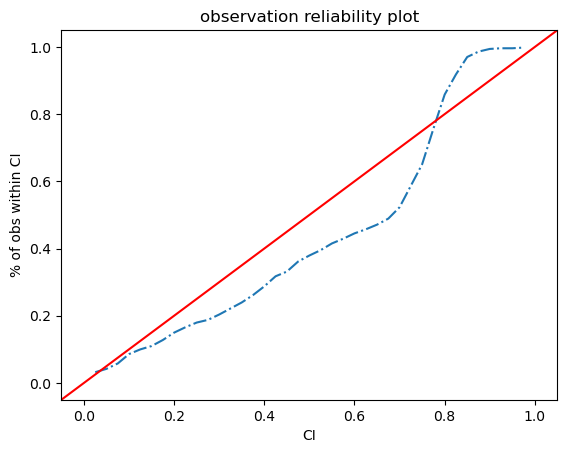

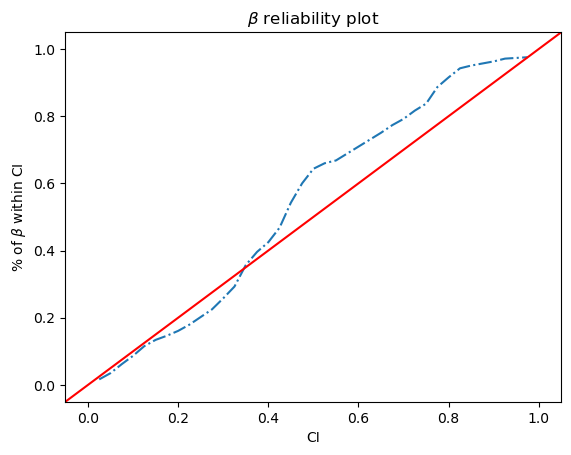

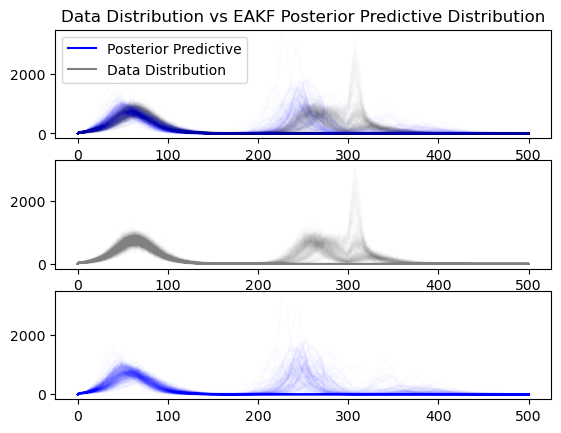

In [188]:
kf_fixed.plot_reliability()
kf_fixed.plot_ppc()

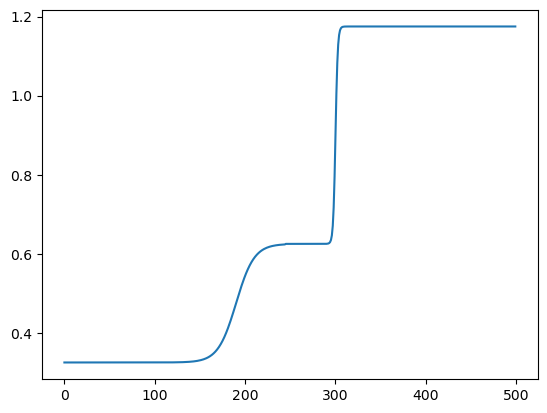

In [189]:
plt.plot(data.beta)

In [190]:
S = np.array([data.S0 * np.ones(300)])
Ir = np.array([data.I0 * np.ones(300)])
R = np.array([np.zeros(300)])
i = np.array([np.zeros(300)])

for t in range(eaks.shape[0]):
    if t < 500:
        dSI = np.random.poisson(data.beta[t] * Ir[t] * S[t] / data.N)
    else:
        dSI = np.random.poisson(eaks[t]/data.t_I*Ir[t]*S[t]/data.N)
    dIR = np.random.poisson(Ir[t]/data.t_I)

    S_new = np.clip(S[t]-dSI, 0, data.N)
    I_new = np.clip(Ir[t]+dSI-dIR, 0, data.N)
    R_new = np.clip(R[t]+dIR, 0, data.N)

    S = np.append(S, [S_new], axis=0)
    Ir = np.append(Ir, [I_new], axis=0)
    R = np.append(R, [R_new], axis=0)
    i = np.append(i, [dSI], axis=0)

eaks_i_ppc = i

In [191]:
S = np.array([data.S0 * np.ones(300)])
Ir = np.array([data.I0 * np.ones(300)])
R = np.array([np.zeros(300)])
i = np.array([np.zeros(300)])

beta = [θ.beta for θ in kf.θ_list]

for t in range(eaks.shape[0]):
    if t < 200:
        dSI = np.random.poisson(data.beta[t] * Ir[t] * S[t] / data.N)
    else:
        dSI = np.random.poisson(beta[t]*Ir[t]*S[t]/data.N)
    dIR = np.random.poisson(Ir[t]/data.t_I)

    S_new = np.clip(S[t]-dSI, 0, data.N)
    I_new = np.clip(Ir[t]+dSI-dIR, 0, data.N)
    R_new = np.clip(R[t]+dIR, 0, data.N)

    S = np.append(S, [S_new], axis=0)
    Ir = np.append(Ir, [I_new], axis=0)
    R = np.append(R, [R_new], axis=0)
    i = np.append(i, [dSI], axis=0)

adapt_i_ppc = i

In [222]:
data.data_distribution.shape

(501, 300)

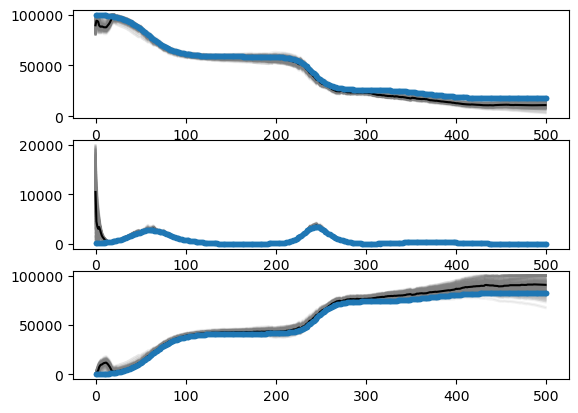

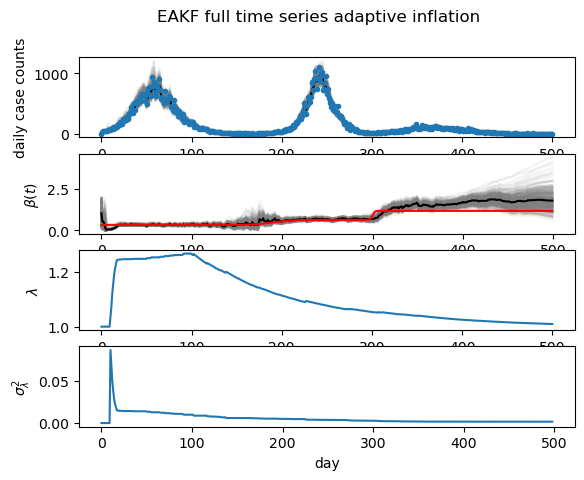

In [321]:
import model_da
importlib.reload(model_da)

model = model_da.SIR_model(data)

import eakf
importlib.reload(eakf)

kf2 = eakf.EnsembleAdjustmentKalmanFilter(model, m=300)

from numpy.random import uniform

prior = {
    'beta':{
        'dist': uniform,
        'args':{
            'low': 0.1,
            'high': 2.,
        }
    },
    't_I':{
        'dist': "constant",
        # 'args':{
        #     'lower': 1.,
        #     'upper': 12.,
        # }
    },
}

kf2.filter(prior)
kf2.plot_posterior()

In [322]:
# import matplotlib.lines as mlines

# fig, ax = plt.subplots(3,2, sharey=True)
# fig.set_figwidth(8)
# fig.set_figheight(6)

# ax[0][0].plot(data.data_distribution, color="gray", alpha=0.05)
# # ax[0][0].plot(data.data_distribution[:,200], marker='x', linewidth=1, alpha=0.5, color='red', label='observed realization')
# # ax[0][0].scatter(np.arange(data.data_distribution.shape[0]), data.data_distribution[:,50], marker='x', color='red', s=3, label='observed realization')
# # ax[0][0].scatter(np.arange(len(data.i)), data.i, marker='x', color='red', s=5, label='observed realization')
# # ax[0][0].legend()
# ax[1][0].plot(kf_no.i_ppc, color="blue", alpha=0.05)
# ax[2][0].plot(kf_fixed.i_ppc, color="purple", alpha=0.05)
# ax[1][1].plot(adapt_i_ppc, color="orange", alpha=0.05)
# ax[2][1].plot(eaks_i_ppc, color="green", alpha=0.05)

# ax[0][1].plot(kf_no.lam_list, color="blue")
# ax[0][1].plot(kf_fixed.lam_list, color="purple")
# ax[0][1].plot(np.concatenate((kf.lam_list[:300], np.ones(len(kf.lam_list)-300))), color="orange")

# ax[0][0].grid()
# ax[1][0].grid()
# ax[2][0].grid()
# ax[0][1].grid()
# ax[1][1].grid()
# ax[2][1].grid()

# # plt.tight_layout(h_pad=1.2, w_pad=1.2)
# plt.subplots_adjust(hspace = 0.4)
# fig.text(0, 0.5, 'daily case counts', va='center', rotation='vertical')
# fig.text(0.5, 0, 'day', ha='center')
# plt.figtext(0.5, 0.64, 'Posterior predictive distributions', ha="center", va="top", fontsize=12)


# gray_line = mlines.Line2D([], [], color='gray', linestyle='-')
# blue_line = mlines.Line2D([], [], color='blue', linestyle='-')
# purple_line = mlines.Line2D([], [], color='purple', linestyle='-')
# orange_line = mlines.Line2D([], [], color='orange', linestyle='-')
# green_line = mlines.Line2D([], [], color='green', linestyle='-')


# handles = [gray_line, blue_line, purple_line, orange_line, green_line]
# labels = ['Data distribution', 'EAKF with no inflation', 'EAKF with adaptive inflation', 'EnSRS (smoothing) with adaptive inflation']
# # Place the legend outside the plots
# fig.legend(handles, labels, loc='upper left')



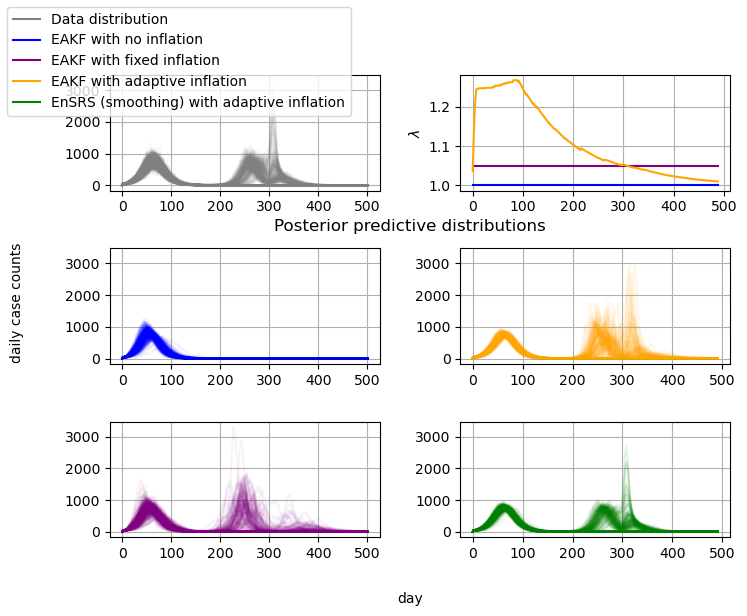

In [326]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(3, 2, width_ratios=[1, 1], height_ratios=[1, 1, 1])

ax1 = plt.subplot(gs[0, 0])
ax1.plot(data.data_distribution, color="gray", alpha=0.05)

ax2 = plt.subplot(gs[1,0], sharey=ax1)
ax2.plot(kf_no.i_ppc, color="blue", alpha=0.05)

ax3 = plt.subplot(gs[2,0], sharey=ax1)
ax3.plot(kf_fixed.i_ppc, color="purple", alpha=0.05)

ax4 = plt.subplot(gs[0,1])
ax4.plot(kf_no.lam_list, color="blue")
ax4.plot(kf_fixed.lam_list[0] * np.ones(len(kf_fixed.lam_list)), color="purple")
ax4.plot(kf2.lam_list, color='orange')
# ax4.plot(np.concatenate((kf2.lam_list[:300], np.ones(len(kf2.lam_list)-300))), color="orange")
ax4.set_ylabel(r'$\lambda$')

ax5 = plt.subplot(gs[1,1], sharey=ax1)
ax5.plot(adapt_i_ppc, color="orange", alpha=0.05)

ax6 = plt.subplot(gs[2,1], sharey=ax1)
ax6.plot(eaks_i_ppc, color="green", alpha=0.05)

ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax5.grid()
ax6.grid()

plt.subplots_adjust(hspace = 0.5, wspace=0.3)
fig.text(0, 0.5, 'daily case counts', va='center', rotation='vertical')
fig.text(0.5, 0, 'day', ha='center')
plt.figtext(0.5, 0.64, 'Posterior predictive distributions', ha="center", va="top", fontsize=12)


gray_line = mlines.Line2D([], [], color='gray', linestyle='-')
blue_line = mlines.Line2D([], [], color='blue', linestyle='-')
purple_line = mlines.Line2D([], [], color='purple', linestyle='-')
orange_line = mlines.Line2D([], [], color='orange', linestyle='-')
green_line = mlines.Line2D([], [], color='green', linestyle='-')


handles = [gray_line, blue_line, purple_line, orange_line, green_line]
labels = ['Data distribution', 'EAKF with no inflation', 'EAKF with fixed inflation', 'EAKF with adaptive inflation', 'EnSRS (smoothing) with adaptive inflation']
# Place the legend outside the plots
fig.legend(handles, labels, loc='upper left')

plt.savefig(f'subplots.svg', format='svg', bbox_inches='tight', transparent=True)

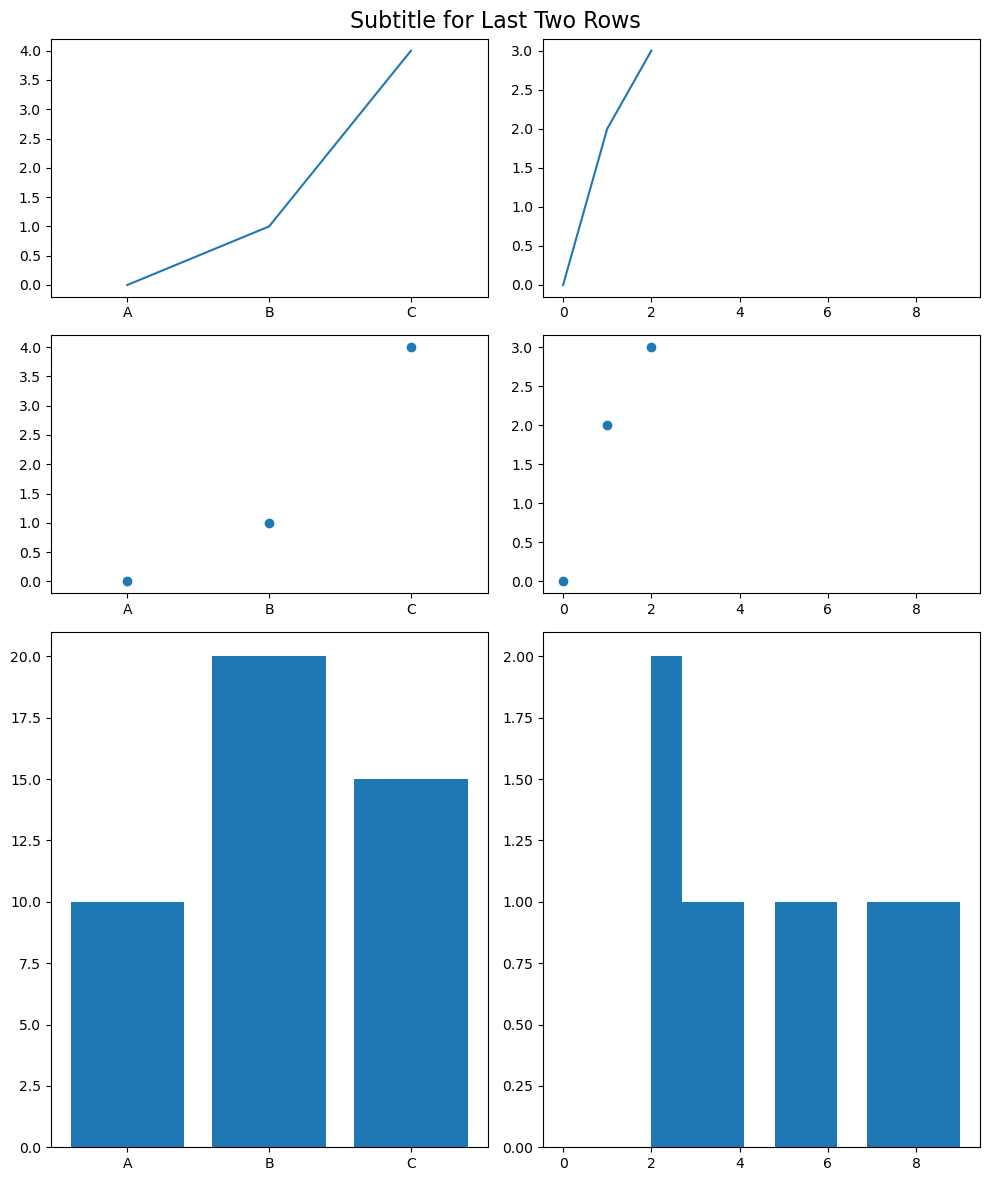

In [319]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create a 3x2 grid of subplots with custom layout
fig = plt.figure(figsize=(10, 12))
gs = gridspec.GridSpec(3, 2, width_ratios=[1, 1], height_ratios=[1, 1, 2])

# Subplot 1 (top left): Share both x and y axes
ax1 = plt.subplot(gs[0, 0])
ax1.plot([0, 1, 2], [0, 1, 4])

# Subplot 2 (top right): Separate y axis
ax2 = plt.subplot(gs[0, 1])
ax2.plot([0, 1, 2], [0, 2, 3])

# Subplot 3 (middle left): Share x axis
ax3 = plt.subplot(gs[1, 0], sharex=ax1)
ax3.scatter([0, 1, 2], [0, 1, 4])

# Subplot 4 (middle right): Share x axis
ax4 = plt.subplot(gs[1, 1], sharex=ax2)
ax4.scatter([0, 1, 2], [0, 2, 3])

# Subplot 5 (bottom left): Share x axis
ax5 = plt.subplot(gs[2, 0], sharex=ax3)
ax5.bar(['A', 'B', 'C'], [10, 20, 15])

# Subplot 6 (bottom right): Share x axis
ax6 = plt.subplot(gs[2, 1], sharex=ax4)
ax6.hist([2, 3, 2, 4, 5, 6, 7, 8, 9])

# Add a subtitle above the last two rows of plots
fig.suptitle('Subtitle for Last Two Rows', fontsize=16)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


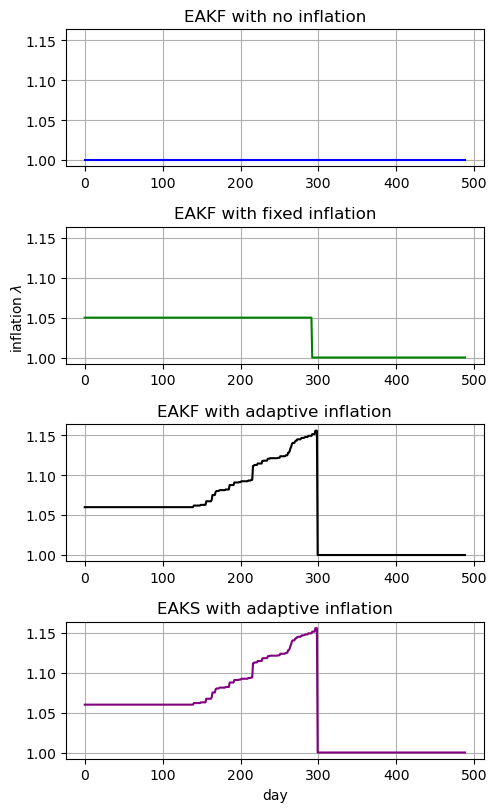

In [286]:
fig, ax = plt.subplots(5, sharey=True)
fig.set_figwidth(5)
fig.set_figheight(10)

ax[1].plot(kf_no.lam_list, color="blue")
ax[2].plot(kf_fixed.lam_list, color="green")
ax[3].plot(np.concatenate((kf.lam_list[:300], np.ones(len(kf.lam_list)-300))), color="black")
ax[4].plot(np.concatenate((kf.lam_list[:300], np.ones(len(kf.lam_list)-300))), color="purple")


# blue_line = plt.Line2D(
#     [], [], color='blue', label='Posterior Predictive')
# grey_line = plt.Line2D(
#     [], [], color='grey', label='Data Distribution')
# ax[0].legend(handles=[blue_line, grey_line])
ax[1].set_title("EAKF with no inflation")
ax[2].set_title("EAKF with fixed inflation")
ax[3].set_title("EAKF with adaptive inflation")
ax[4].set_title("EAKS with adaptive inflation")
ax[4].set_xlabel('day')
ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[3].grid()
ax[4].grid()

plt.tight_layout(h_pad=1.2, w_pad=1.2)
fig.text(0, 0.5, r'inflation $\lambda$', va='center', rotation='vertical')

fig.delaxes(ax[0])


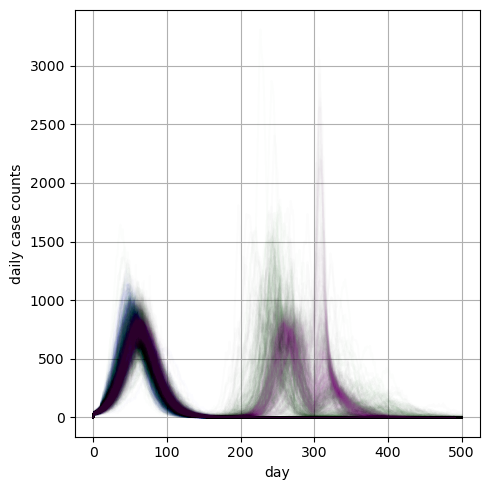

In [194]:
fig, ax = plt.subplots(1)
fig.set_figwidth(5)
fig.set_figheight(5)

ax.plot(data.data_distribution, color="gray", alpha=0.01)
ax.plot(kf_no.i_ppc, color="blue", alpha=0.01)
ax.plot(kf_fixed.i_ppc, color="green", alpha=0.01)
ax.plot(kf.i_ppc, color="black", alpha=0.01)
ax.plot(eaks_i_ppc, color="purple", alpha=0.01)


# blue_line = plt.Line2D(
#     [], [], color='blue', label='Posterior Predictive')
# grey_line = plt.Line2D(
#     [], [], color='grey', label='Data Distribution')
# ax[0].legend(handles=[blue_line, grey_line])
ax.set_xlabel('day')
ax.set_ylabel('daily case counts')

plt.tight_layout(h_pad=1.2, w_pad=1.2)
ax.grid()

Text(0.5, 1.0, 'Synthetic Truth')

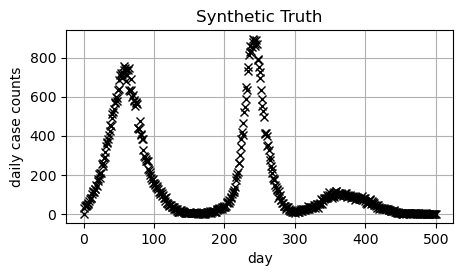

In [195]:
fig, ax = plt.subplots(figsize=(5,10/4))
ax.plot(data.i_true, 'x', color='black')
ax.set_xlabel('day')
ax.set_ylabel('daily case counts')
ax.grid()
ax.set_title('Synthetic Truth')
